In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

import keras
import os
import re
import torch 
import transformers
import gzip

from collections import Counter, defaultdict
from itertools import islice
from tqdm import trange, tqdm
from torch.optim import Adam
from transformers import BertTokenizer, BertModel, BertForQuestionAnswering, DistilBertTokenizer, DistilBertForQuestionAnswering
from transformers import AdamW
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup

from eval_squad import *
from models.QAModels import *
from models.utils import *
from utils import *

%matplotlib inline

Using TensorFlow backend.


In [2]:
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-cased')

In [30]:
def freeze_transformer_layers(
                              model,
                              model_name:str,
                              unfreeze:bool,
                              l:int=None,
):
    model_names = ['bert', 'distilbert']
    model_name = model_name.lower()
    if model_name not in model_names:
        raise ValueError('Incorrect model name provided. Model name must be one of {}'.format(model_names))

    for n, p in model.named_parameters():
        if n.startswith(model_name):
            if unfreeze:
                assert isinstance(l, int)
                transformer_layer = model_name + '.transformer.layer.' if model_name == 'distilbert' else model_name + '.encoder.layer.' 
                pooling_layer = model_name + '.pooler.'
                if re.search(r'' + transformer_layer, n):
                    n_digits = '1' if model_name == 'distilbert' else '2'
                    if re.search(r'[0-9]{' + n_digits + '}', n):
                        layer_no = n[len(transformer_layer): len(transformer_layer) + int(n_digits)]
                        if int(layer_no) >= l:
                            p.requires_grad = True
                elif re.search(r'' + pooling_layer, n):
                    p.requires_grad =True
            else:
                p.requires_grad = False
                
    return model


In [31]:
model = freeze_transformer_layers(model, model_name='distilbert', unfreeze=False)
model = freeze_transformer_layers(model, model_name='distilbert', unfreeze=True, l=5)

In [32]:
for n, p in model.named_parameters():
    print(n, p.requires_grad)

distilbert.embeddings.word_embeddings.weight False
distilbert.embeddings.position_embeddings.weight False
distilbert.embeddings.LayerNorm.weight False
distilbert.embeddings.LayerNorm.bias False
distilbert.transformer.layer.0.attention.q_lin.weight False
distilbert.transformer.layer.0.attention.q_lin.bias False
distilbert.transformer.layer.0.attention.k_lin.weight False
distilbert.transformer.layer.0.attention.k_lin.bias False
distilbert.transformer.layer.0.attention.v_lin.weight False
distilbert.transformer.layer.0.attention.v_lin.bias False
distilbert.transformer.layer.0.attention.out_lin.weight False
distilbert.transformer.layer.0.attention.out_lin.bias False
distilbert.transformer.layer.0.sa_layer_norm.weight False
distilbert.transformer.layer.0.sa_layer_norm.bias False
distilbert.transformer.layer.0.ffn.lin1.weight False
distilbert.transformer.layer.0.ffn.lin1.bias False
distilbert.transformer.layer.0.ffn.lin2.weight False
distilbert.transformer.layer.0.ffn.lin2.bias False
distilbe

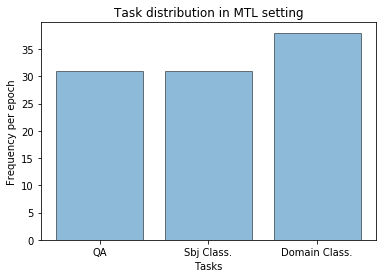

<Figure size 432x288 with 0 Axes>

In [21]:
tasks = ['QA', 'Sbj Class.', 'Domain Class.']
task_order = np.random.choice(tasks, size=100, replace=True)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [4]:
#model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [18]:
#for n, p in model.named_parameters():
#    print(n, p.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

bert.encoder.layer.18.output.LayerNorm.bias True
bert.encoder.layer.19.attention.self.query.weight True
bert.encoder.layer.19.attention.self.query.bias True
bert.encoder.layer.19.attention.self.key.weight True
bert.encoder.layer.19.attention.self.key.bias True
bert.encoder.layer.19.attention.self.value.weight True
bert.encoder.layer.19.attention.self.value.bias True
bert.encoder.layer.19.attention.output.dense.weight True
bert.encoder.layer.19.attention.output.dense.bias True
bert.encoder.layer.19.attention.output.LayerNorm.weight True
bert.encoder.layer.19.attention.output.LayerNorm.bias True
bert.encoder.layer.19.intermediate.dense.weight True
bert.encoder.layer.19.intermediate.dense.bias True
bert.encoder.layer.19.output.dense.weight True
bert.encoder.layer.19.output.dense.bias True
bert.encoder.layer.19.output.LayerNorm.weight True
bert.encoder.layer.19.output.LayerNorm.bias True
bert.encoder.layer.20.attention.self.query.weight True
bert.encoder.layer.20.attention.self.query.bias 

## Load QA data into memory

In [3]:
# load SubjQA_data into memory
subjqa_data_train, hidden_domain_idx_train = get_data(
                                                     source='/SubjQA/',
                                                     split='/train',
                                                     domain='all',
)

subjqa_data_dev, hidden_domain_idx_dev = get_data(
                                                  source='/SubjQA/',
                                                  split='/dev',
                                                  domain='all',
)

subjqa_data_test, hidden_domain_idx_test = get_data(
                                                    source='/SubjQA/',
                                                    split='/test',
                                                    domain='all',
)

# convert pd.DataFrames into list of dictionaries (as many dicts as examples)
subjqa_data_train = convert_df_to_dict(
                                       subjqa_data_train,
                                       hidden_domain_indexes=hidden_domain_idx_train,
                                       split='train',
)
subjqa_data_dev = convert_df_to_dict(
                                     subjqa_data_dev,
                                     hidden_domain_indexes=hidden_domain_idx_dev,
                                     split='dev',
)
subjqa_data_test = convert_df_to_dict(
                                      subjqa_data_test,
                                      hidden_domain_indexes=hidden_domain_idx_test,
                                      split='test',
)

In [4]:
# load SQuAD_data into memory
squad_data_train = get_data(
                            source='/SQuAD/',
                            split='train',
)

#NOTE: we don't have correct answer spans (i.e., start and end positions) for SQuAD dev set (predictions need to be submitted)
squad_data_test = get_data(
                          source='/SQuAD/',
                          split='dev',
)

## Define hyperparameters

In [5]:
# TODO: figure out, whether we should use pretrained weights from 'bert-base-cased' or 'bert-base-uncased' model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# choose pretrained weights
pretrained_weights = 'bert-large-cased-whole-word-masking-finetuned-squad'

# BERT cannot deal with sequences, where T > 512
max_seq_length = 512

# defin mini-batch size
batch_size = 32

# create domain_to_idx and dataset_to_idx mappings
domains = ['books', 'electronics', 'grocery', 'movies', 'restaurants', 'trustyou', 'tripadvisor', 'all', 'wikipedia']
datasets = ['SQuAD', 'SubjQA']

idx_to_domain = dict(enumerate(domains))
domain_to_idx = {domain: idx for idx, domain in enumerate(domains)}

idx_to_dataset = dict(enumerate(datasets))
dataset_to_idx = {dataset: idx for idx, dataset in enumerate(datasets)}

## Create train and dev QA examples

In [6]:
subjqa_examples_train = create_examples(
                                        subjqa_data_train,
                                        source='SubjQA',
                                        is_training=True,
)

subjqa_examples_dev = create_examples(
                                      subjqa_data_dev,
                                      source='SubjQA',
                                      is_training=True,
)

In [7]:
squad_examples_train = create_examples(
                                       squad_data_train,
                                       source='SQuAD',
                                       is_training=True,
)

# create train and dev examples from train set only
squad_examples_train, squad_examples_dev = split_into_train_and_dev(squad_examples_train)

## Create train and dev QA features

In [8]:
subjqa_features_train = convert_examples_to_features(
                                                    subjqa_examples_train, 
                                                    bert_tokenizer,
                                                    max_seq_length=max_seq_length,
                                                    doc_stride=200,
                                                    max_query_length=50,
                                                    is_training=True,
                                                    domain_to_idx=domain_to_idx,
                                                    dataset_to_idx=dataset_to_idx,
)

subjqa_features_dev = convert_examples_to_features(
                                                    subjqa_examples_dev, 
                                                    bert_tokenizer,
                                                    max_seq_length=max_seq_length,
                                                    doc_stride=200,
                                                    max_query_length=50,
                                                    is_training=True,
                                                    domain_to_idx=domain_to_idx,
                                                    dataset_to_idx=dataset_to_idx,
)

In [9]:
squad_features_train = convert_examples_to_features(
                                                    squad_examples_train, 
                                                    bert_tokenizer,
                                                    max_seq_length=max_seq_length,
                                                    doc_stride=200,
                                                    max_query_length=50,
                                                    is_training=True,
                                                    domain_to_idx=domain_to_idx,
                                                    dataset_to_idx=dataset_to_idx,
)

squad_features_dev = convert_examples_to_features(
                                                squad_examples_dev, 
                                                bert_tokenizer,
                                                max_seq_length=max_seq_length,
                                                doc_stride=200,
                                                max_query_length=50,
                                                is_training=True,
                                                domain_to_idx=domain_to_idx,
                                                dataset_to_idx=dataset_to_idx,
)

## Create train and dev QA tensor datasets

In [10]:
subjqa_tensor_dataset_train = create_tensor_dataset(
                                                   subjqa_features_train,
                                                   evaluate=False,
)

subjqa_tensor_dataset_dev = create_tensor_dataset(
                                                  subjqa_features_dev,
                                                  evaluate=False,
)

In [41]:
squad_tensor_dataset_train = create_tensor_dataset(
                                                   squad_features_train,
                                                   evaluate=False,
)

squad_tensor_dataset_dev = create_tensor_dataset(
                                                 squad_features_dev,
                                                 evaluate=False,
)

## Create individual train and dev dataloaders (separately for SQuAD and SubjQA)

In [12]:
subjqa_train_dl = create_batches(
                                dataset=subjqa_tensor_dataset_train,
                                batch_size=batch_size,
                                split='train',
)

subjqa_dev_dl = create_batches(
                              dataset=subjqa_tensor_dataset_dev,
                              batch_size=batch_size,
                              split='eval',
)

In [13]:
squad_train_dl = create_batches(
                                dataset=squad_tensor_dataset_train,
                                batch_size=batch_size,
                                split='train',
)

squad_dev_dl = create_batches(
                              dataset=squad_tensor_dataset_dev,
                              batch_size=batch_size,
                              split='eval',
)

## Create combined train and dev dataloaders (merge SQuAD and SubjQA)

In [153]:
train_dl_combined = AlternatingBatchGenerator(
                                             squad_tensor_dataset_train,
                                             subjqa_tensor_dataset_train,
                                             batch_size=batch_size,
                                             split='train',
)

dev_dl_combined = AlternatingBatchGenerator(
                                            squad_tensor_dataset_train,
                                            subjqa_tensor_dataset_train,
                                            batch_size=batch_size,
                                            split='eval',
)

## Initialise QA model

In [154]:
# initialise QA model
model = BertForQA.from_pretrained(
                                 pretrained_weights,
                                 qa_head_name='RecurrentQAHead',
                                 max_seq_length=max_seq_length,
                                 highway_connection=True,
                                 multitask=False,
)

# set model to device
model.to(device)

BertForQA(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_af

In [155]:
args = {
        "n_epochs": 3,
        "lr": 1e-3,
        "warmup_steps": 100,
        "max_grad_norm": 10,
        "squad": True,
}

In [ ]:
train(
     model=model,
     tokenizer=bert_tokenizer,
     train_dl=subjqa_train_dl,
     val_dl=subjqa_dev_dl,
     batch_size=batch_size,
     args=args,
)

In [156]:
train(
     model=model,
     tokenizer=bert_tokenizer,
     train_dl=train_dl_combined,
     val_dl=dev_dl_combined,
     batch_size=batch_size,
     args=args,
)

------ Pre-trained BERT model is frozen -------






Epoch:   0%|                                                                                     | 0/3 [00:00<?, ?it/s]




Iteration:   0%|                                                                              | 0/1272 [00:00<?, ?it/s]

Current batch loss: 6.228058815002441

Current batch exact-match: 0.0 %
Current batch F1: 1.992038426108698 %








Iteration:   0%|                                                                  | 1/1272 [02:03<43:27:05, 123.07s/it]

Current batch loss: 6.229662895202637

Current batch exact-match: 0.0 %
Current batch F1: 1.015923671653075 %








Iteration:   0%|                                                                  | 2/1272 [03:55<42:15:59, 119.81s/it]

Current batch loss: 6.168371200561523

Current batch exact-match: 3.125 %
Current batch F1: 6.597295008406277 %








Iteration:   0%|▏                                                                 | 3/1272 [05:52<41:59:44, 119.14s/it]

Current batch loss: 6.033244609832764

Current batch exact-match: 4.6875 %
Current batch F1: 9.684421627413602 %








Iteration:   0%|▏                                                                 | 4/1272 [07:59<42:43:44, 121.31s/it]

KeyboardInterrupt: 